# Boundary vector score (BVS) - datajoint integration

Datajoint integration of bvs calculation

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
# Set up basics
import sys, os
import numpy as np 
from collections import OrderedDict
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

import datajoint as dj
import pandas as pd

In [3]:
# Load base schema
schema = dj.schema(dj.config['dj_imaging.database'])
schema.spawn_missing_classes()

Connecting horsto@kavlidatajoint02.it.ntnu.no:3306


### Schema components

In [4]:
from dj_schemas.bvs import *

In [5]:
BVField().progress()

BVField              Completed 213972 of 213974 (100.0%)   2020-11-22 18:00:15


(2, 213974)

In [6]:
BVScore().progress()

BVScore              Completed 427934 of 427944 (100.0%)   2020-11-22 18:00:40


(10, 427944)

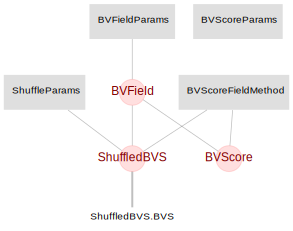

In [89]:
dj.ERD(BVFieldParams) + dj.ERD(BVScoreParams) + dj.ERD(BVScoreFieldMethod)+1+ ShuffledBVS + ShuffledBVS.BVS + ShuffleParams

In [20]:
from collections import OrderedDict

In [21]:
cell_parameter_dict = OrderedDict([('ang_params_id', 'A'),
             ('border_params_id', 'A'),
             ('channel', 'primary'),
             ('field_params_id', 'A'),
             ('grid_params_id', 'A'),
             ('map_params_id', 'A'),
             ('noise_calc_id', 'A'),
             ('ov_cutoff_id', 'A'),
             ('ov_params_id', 'A'),
             ('s_t_params_id', 'A'),
             ('shuffle_params_id', 'A'),
             ('signal_type', 'spikes'),
             ('spike_filter_id', 'A'),
             ('trackingparams_id', 'A')])

### Compare scores across field detection methods

In [51]:
bvscores_entries = (BVScore & cell_parameter_dict)
bvscores_df      = pd.DataFrame(bvscores_entries.fetch(as_dict=True))

In [52]:
bvscores_df.head()

,metasession_name,session_order,session_name,signal_dataset,cell_id,channel,spike_filter_id,tracking_dataset,trackingparams_id,s_t_params_id,signal_type,map_params_id,field_params_id,bvfield_params_id,bv_field_dect_method,bvs,orientation
0,010817cb5e4a1ae5,0,d6ba671faad74695,2defc4b09cb2ce57,3,primary,A,24a0025370060e41,A,A,spikes,A,A,A,opexebo,0.438004,None
1,010817cb5e4a1ae5,0,d6ba671faad74695,2defc4b09cb2ce57,3,primary,A,24a0025370060e41,A,A,spikes,A,A,A,bvs,0.435484,horizontal
2,010817cb5e4a1ae5,0,d6ba671faad74695,2defc4b09cb2ce57,5,primary,A,24a0025370060e41,A,A,spikes,A,A,A,opexebo,0.378024,horizontal
3,010817cb5e4a1ae5,0,d6ba671faad74695,2defc4b09cb2ce57,5,primary,A,24a0025370060e41,A,A,spikes,A,A,A,bvs,0.306452,None
4,010817cb5e4a1ae5,0,d6ba671faad74695,2defc4b09cb2ce57,7,primary,A,24a0025370060e41,A,A,spikes,A,A,A,opexebo,0.469254,vertical


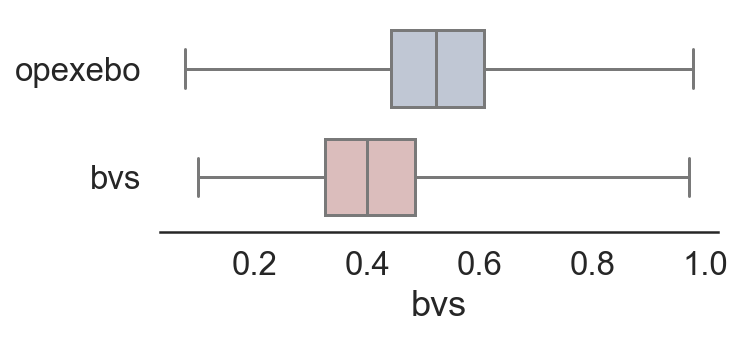

In [90]:
sns.set(style='white',font_scale=1.5)
f, ax = plt.subplots(figsize=(5, 2))
sns.boxplot(x="bvs", y="bv_field_dect_method", data=bvscores_df,
            whis=[0, 100], width=.7, palette="vlag")
#sns.stripplot(x="bvs", y="bv_field_dect_method", data=bvscores_df,
#              size=4, color=".3", alpha=.05, linewidth=0)

ax.set(ylabel="")
sns.despine(left=True,bottom=False, trim=False)

In [66]:
# Quick summary BVS
bvscores_df.pivot_table(columns='bv_field_dect_method', values='bvs')

bv_field_dect_method,bvs,opexebo
bvs,0.414338,0.526516


In [72]:
bvscores_df_pivot = bvscores_df.pivot_table(index=['session_name','cell_id'], columns='bv_field_dect_method', values='bvs')

Text(0, 0.5, 'Opexebo detection [opexebo]')

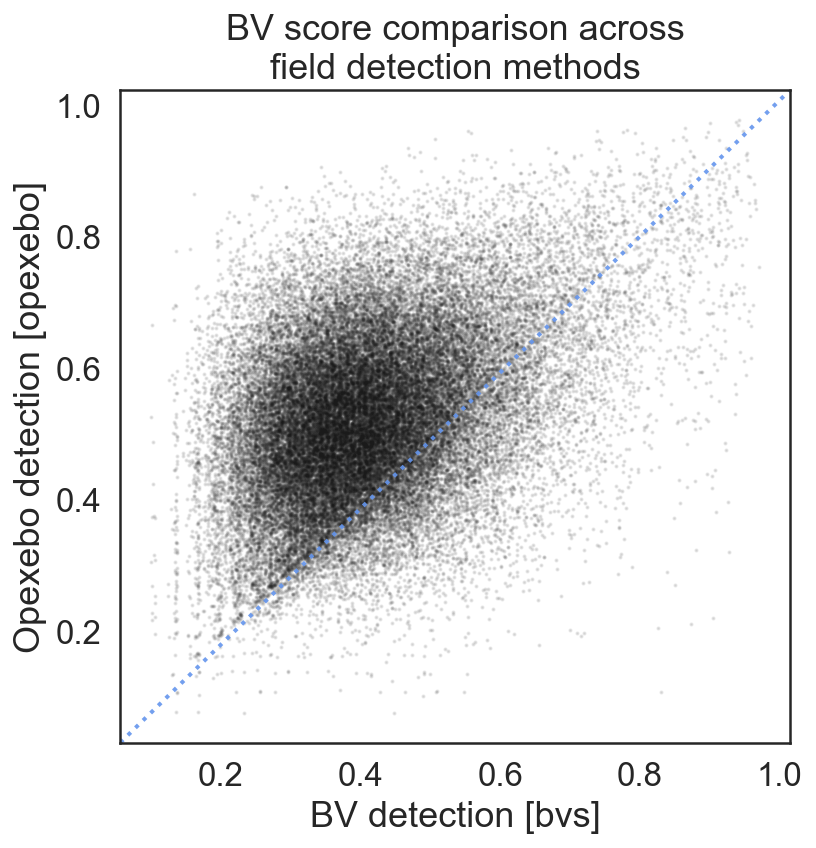

In [93]:
figure = plt.figure(figsize=(6,6))
ax = figure.add_subplot(111)
ax.scatter(bvscores_df_pivot.bvs, 
           bvscores_df_pivot.opexebo, 
           s=1, alpha=.1, color='k')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=2, color='cornflowerblue',alpha=.9, ls=':')


ax.set_title('BV score comparison across\nfield detection methods')
ax.set_xlabel('BV detection [bvs]')
ax.set_ylabel('Opexebo detection [opexebo]')

### Shuffling

In [94]:
ShuffleParams()

"shuffle_params_id Parameter set ID, starting with A",number_shuffles Expected number of shuffles,"margin_seconds Margin in seconds at start, end of sync samples",break_seconds Break in seconds between sync samples (-> non-continuous sampling of sync stream)
A,500,2.0,0.5


In [95]:
from dj_schemas.shuffling_bvs import * 

In [96]:
ShuffledBVS.progress()

ShuffledBVS          Completed 35349 of 427944 (8.3%)   2020-11-22 18:58:46


(392595, 427944)

In [143]:
borderscore_cutoff = .37 # 95th: .37, 99th: .48

In [153]:
bvs_examples = BorderScore * BVScore \
                & 'bvs > .56' \
                & f'borderscore > {borderscore_cutoff}' \
                & 'bv_field_dect_method = "bvs"'\
                & cell_parameter_dict
print(len(bvs_examples))

2039


Fetched 21 examples


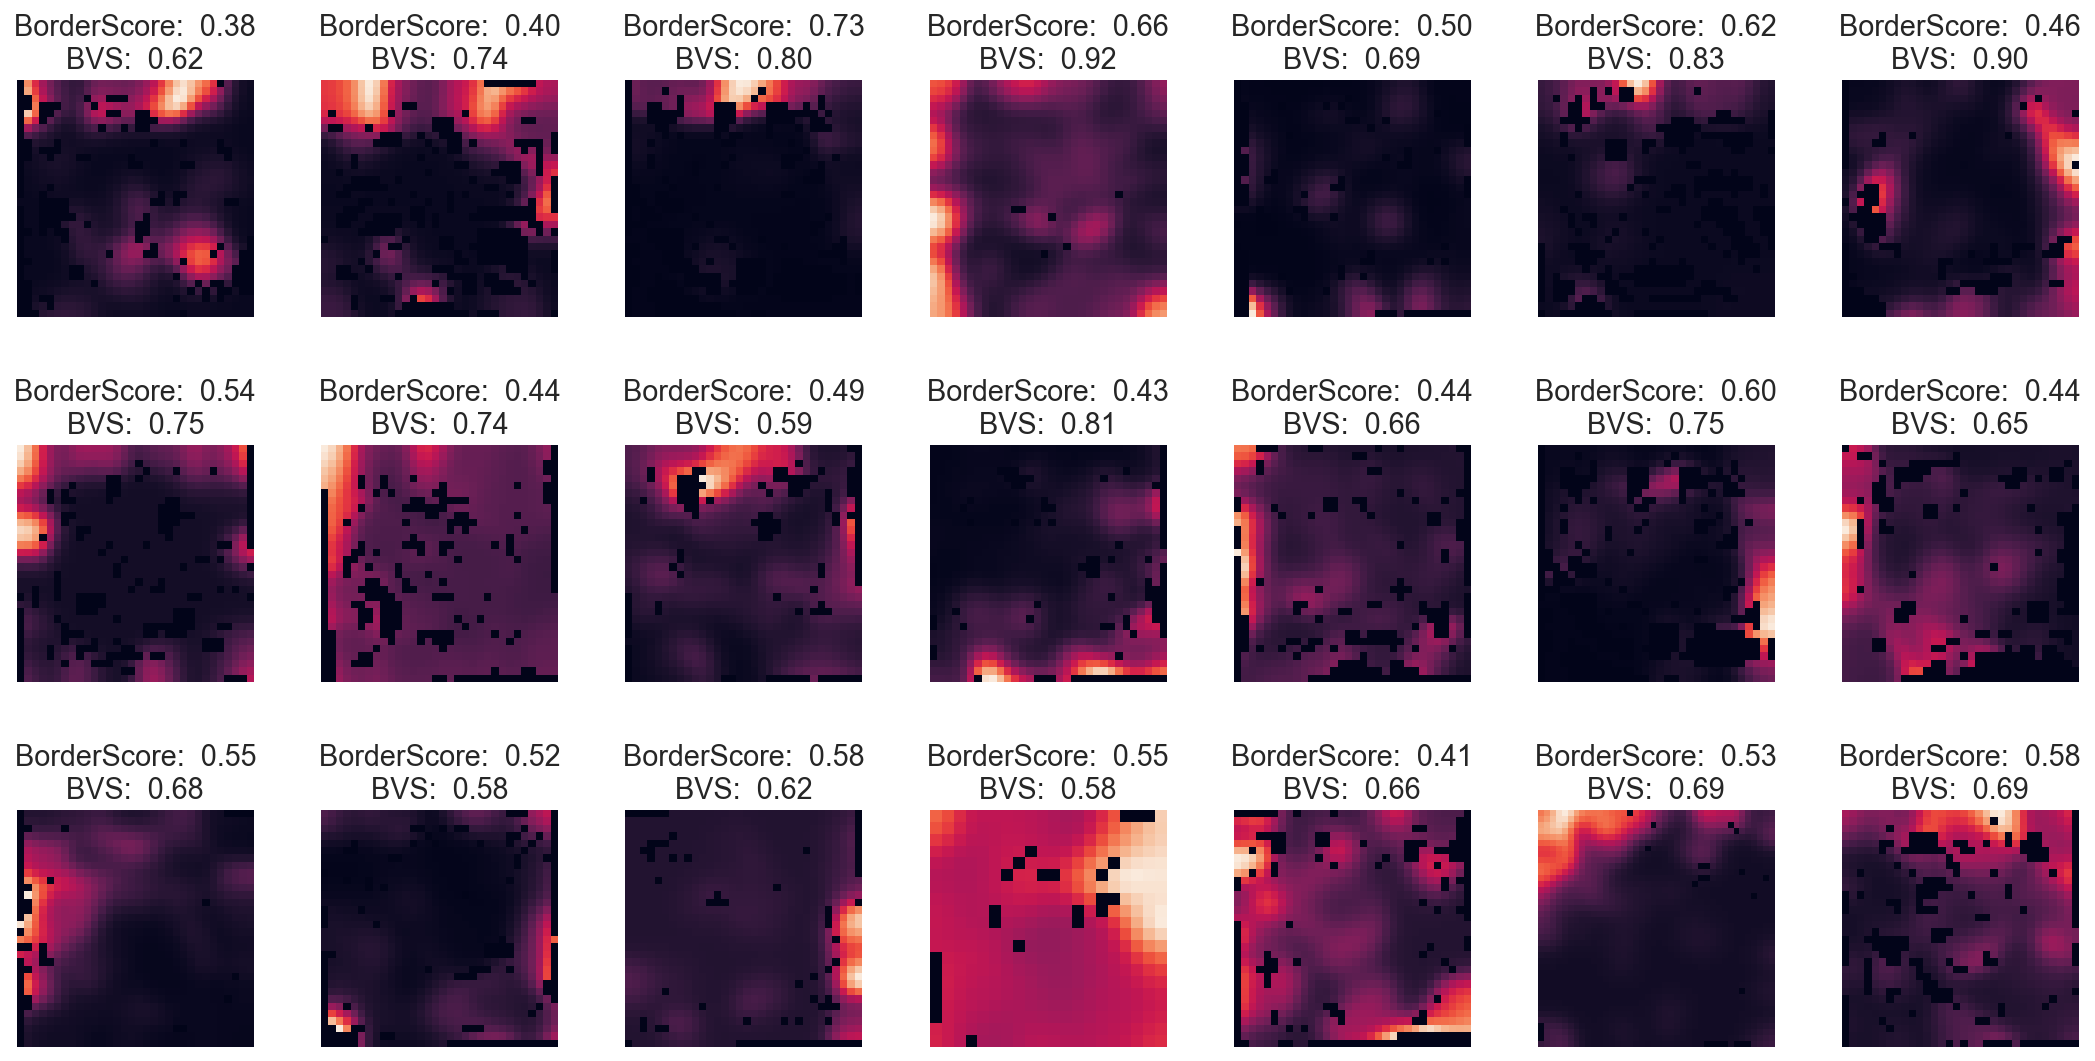

In [157]:
some_bvs = bvs_examples.fetch(limit=21, order_by='RAND()', as_dict=True)
print(f'Fetched {len(some_bvs)} examples')
figure = plt.figure(figsize=(15,8))
for no,rm in enumerate(some_bvs):
    ax = figure.add_subplot(3,7,no+1)
    bvs = rm['bvs']
    borderscore = (BorderScore & rm).fetch1("borderscore")
    ratemap_entry = (Ratemap & rm).fetch1()
    rm      = np.ma.array(ratemap_entry['ratemap'], mask = ratemap_entry['mask_rm'])
    rm_nans = np.ma.filled(rm, fill_value=-10).astype(np.float64)
    ax.imshow(rm_nans)
    ax.set_title(f'BorderScore:  {borderscore:.2f}\nBVS:  {bvs:.2f}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    sns.despine(left=True,bottom=True)
plt.tight_layout()

### Distributions

In [129]:
field_method = 'bvs' # 'bvs', 'opexebo'

In [130]:
all_bvs = (BVScore  & 'signal_type = "spikes"' & 'map_params_id = "A"' & f'bv_field_dect_method = "{field_method}"').fetch('bvs')
bvs_99, bvs_95 = (ShuffledBVS.BVS & 'signal_type = "spikes"' & 'map_params_id = "A"' & f'bv_field_dect_method = "{field_method}"').fetch('bvs_99','bvs_95')

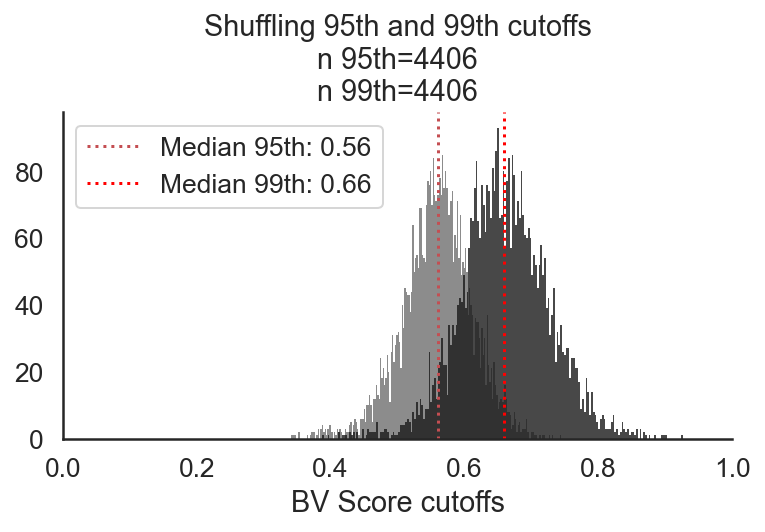

In [131]:
sns.set(style='white',font_scale=1.2)
figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(111)
ax.hist(bvs_95,bins=200, lw=0,color='k',alpha=.5);
ax.hist(bvs_99,bins=200, lw=0,color='k',alpha=.8);
median_95 = np.nanmedian(bvs_95)
median_99 = np.nanmedian(bvs_99)
ax.axvline(x=median_95,ls=':',color='r', label=f'Median 95th: {median_95:.2f}')
ax.axvline(x=median_99,ls=':',color='red', label=f'Median 99th: {median_99:.2f}')
ax.legend()
ax.set_xlim(0,1)
ax.set_xlabel('BV Score cutoffs')
ax.set_title(f'Shuffling 95th and 99th cutoffs\nn 95th={len(bvs_95)}\nn 99th={len(bvs_99)}')
sns.despine()

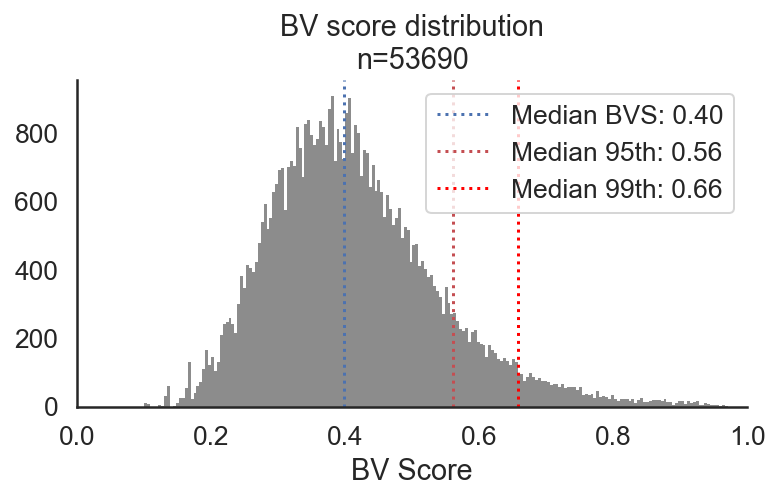

In [132]:
sns.set(style='white',font_scale=1.2)
figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(111)
ax.hist(all_bvs,bins=200, lw=0,color='k',alpha=.5);
median_bvs = np.nanmedian(all_bvs)
ax.axvline(x=median_bvs,ls=':',color='b', label=f'Median BVS: {median_bvs:.2f}')
ax.axvline(x=median_95,ls=':',color='r', label=f'Median 95th: {median_95:.2f}')
ax.axvline(x=median_99,ls=':',color='red', label=f'Median 99th: {median_99:.2f}')
ax.legend()
ax.set_xlabel('BV Score')
ax.set_title(f'BV score distribution\nn={len(all_bvs)}')
ax.set_xlim(0,1)
sns.despine()

### ... borderscore

In [133]:
all_borderscores = (BorderScore  & 'signal_type = "spikes"' & 'map_params_id = "A"').fetch('borderscore')
bordersc_99, bordersc_95 = (Shuffled.BorderScore & 'map_params_id = "A"').fetch('borderscore_99','borderscore_95')

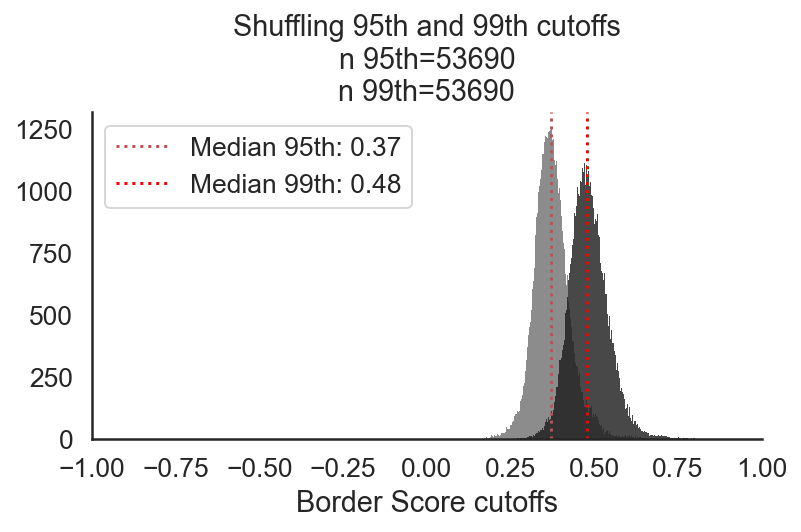

In [134]:
sns.set(style='white',font_scale=1.2)
figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(111)
ax.hist(bordersc_95,bins=200, lw=0,color='k',alpha=.5);
ax.hist(bordersc_99,bins=200, lw=0,color='k',alpha=.8);
median_95 = np.nanmedian(bordersc_95)
median_99 = np.nanmedian(bordersc_99)
ax.axvline(x=median_95,ls=':',color='r', label=f'Median 95th: {median_95:.2f}')
ax.axvline(x=median_99,ls=':',color='red', label=f'Median 99th: {median_99:.2f}')
ax.legend()
ax.set_xlim(-1,1)
ax.set_xlabel('Border Score cutoffs')
ax.set_title(f'Shuffling 95th and 99th cutoffs\nn 95th={len(bordersc_95)}\nn 99th={len(bordersc_99)}')
sns.despine()

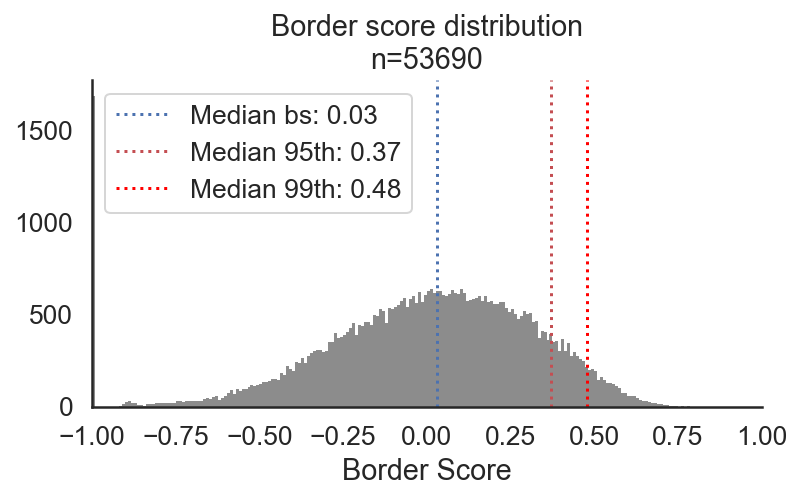

In [135]:
sns.set(style='white',font_scale=1.2)
figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(111)
ax.hist(all_borderscores,bins=200, lw=0,color='k',alpha=.5);
median_bs = np.nanmedian(all_borderscores)
ax.axvline(x=median_bs,ls=':',color='b', label=f'Median bs: {median_bs:.2f}')
ax.axvline(x=median_95,ls=':',color='r', label=f'Median 95th: {median_95:.2f}')
ax.axvline(x=median_99,ls=':',color='red', label=f'Median 99th: {median_99:.2f}')
ax.legend()
ax.set_xlabel('Border Score')
ax.set_title(f'Border score distribution\nn={len(all_bvs)}')
ax.set_xlim(-1,1)
sns.despine()

In [136]:
bs  = (BorderScore  & 'signal_type = "spikes"' & 'map_params_id = "A"')
bvs = (BVScore  & 'signal_type = "spikes"' & 'map_params_id = "A"' & f'bv_field_dect_method = "{field_method}"')
combined = bs * bvs

In [137]:
all_bvs_, all_bs_ = combined.fetch('bvs','borderscore')

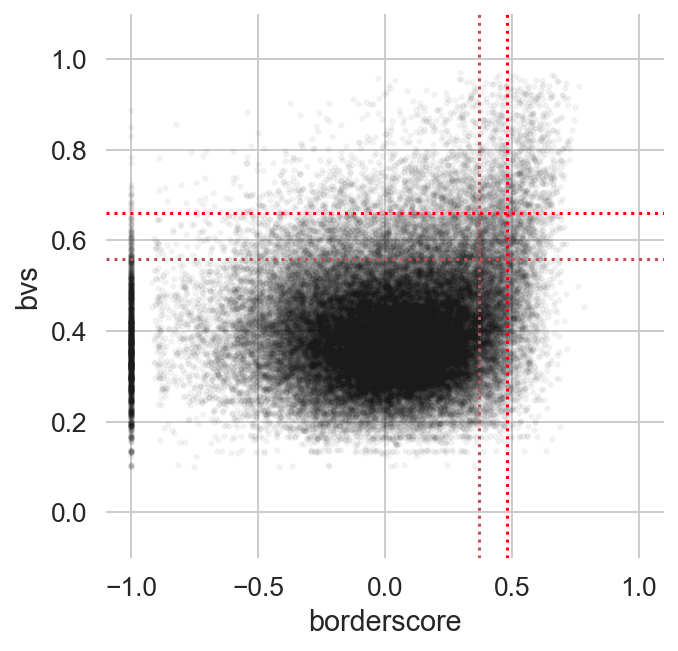

In [139]:
sns.set(style='whitegrid',font_scale=1.2)
figure = plt.figure(figsize=(5,5))
ax = figure.add_subplot(111)

ax.scatter(all_bs_, all_bvs_, s=5, color='k', alpha=.04)
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-.1,1.1)

# draw in cutoffs
ax.axvline(x=.37,ls=':',color='r')
ax.axvline(x=.48,ls=':',color='red')

ax.axhline(y=.56,ls=':',color='r')
ax.axhline(y=.66,ls=':',color='red')

ax.set_xlabel('borderscore')
ax.set_ylabel('bvs')
sns.despine(left=True,bottom=True)